In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer # Used for Varimax rotation

# Set plotting style
plt.style.use('ggplot')
print("Libraries imported successfully!")

Libraries imported successfully!


In [11]:
%pip install openpyxl
%pip install jinja2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Load dataset from Excel
file_path = 'Summary table.xlsx'
df = pd.read_excel(file_path)

# Define ID column and the 7 features for analysis
id_col = 'DeSO'
features = [
    'norm_15yr_lower', 
    'norm_65yr_higher', 
    'norm_unemployment', 
    'norm_foreign_born', 
    'norm_medium_income', 
    'norm_low_eco', 
    'norm_low_education'
]

# Verify data loading
print(f"Data loaded successfully: {len(df)} rows.")
df[features].head()

Data loaded successfully: 544 rows.


,norm_15yr_lower,norm_65yr_higher,norm_unemployment,norm_foreign_born,norm_medium_income,norm_low_eco,norm_low_education
0,0.520085,0.516575,0.387354,0.454211,0.363651,0.400000,0.431119
1,0.481072,0.518277,0.439840,0.423241,0.377460,0.366667,0.444854
2,0.621235,0.564679,0.125042,0.168395,0.537619,0.116667,0.179848
3,0.573871,0.340832,0.293148,0.396139,0.473651,0.250000,0.357381
4,0.589314,0.418299,0.126155,0.264799,0.552063,0.133333,0.193642


In [16]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the feature columns (Z-score normalization)
X_scaled = scaler.fit_transform(df[features])

# Convert scaled data back to DataFrame for better readability
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

print("Data standardization (Z-score) complete. Top 5 rows preview:")
print(X_scaled_df.head().round(3))

Data standardization (Z-score) complete. Top 5 rows preview:
   norm_15yr_lower  norm_65yr_higher  norm_unemployment  norm_foreign_born  \
0            0.006             0.820              1.126              0.905   
1           -0.217             0.832              1.422              0.756   
2            0.584             1.148             -0.353             -0.468   
3            0.314            -0.378              0.595              0.626   
4            0.402             0.150             -0.347             -0.005   

   norm_medium_income  norm_low_eco  norm_low_education  
0              -1.457         1.428               1.066  
1              -1.365         1.206               1.135  
2              -0.293        -0.461              -0.197  
3              -0.721         0.428               0.695  
4              -0.196        -0.350              -0.128  


--- Eigenvalue Analysis ---
Component 1: 4.6350
Component 2: 1.2935
Component 3: 0.6393
Component 4: 0.1781
Component 5: 0.1561
Component 6: 0.0689
Component 7: 0.0420

> Based on Kaiser Criterion (Eigenvalue > 1), suggested number of components: 2


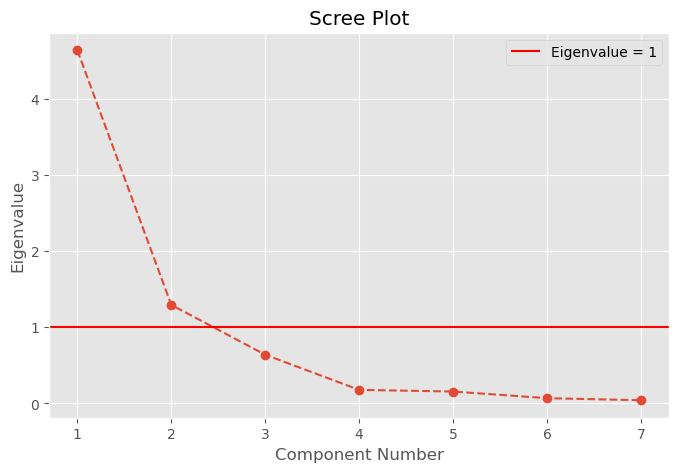

In [17]:
# Calculate eigenvalues using initial PCA
pca_init = PCA().fit(X_scaled)
eigenvalues = pca_init.explained_variance_

# Determine the number of components with eigenvalues > 1 (Kaiser Criterion)
n_components = sum(eigenvalues > 1)

print("--- Eigenvalue Analysis ---")
for i, val in enumerate(eigenvalues):
    print(f"Component {i+1}: {val:.4f}")

print(f"\n> Based on Kaiser Criterion (Eigenvalue > 1), suggested number of components: {n_components}")

# Plot the Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', linestyle='--')
plt.axhline(y=1, color='r', linestyle='-', label='Eigenvalue = 1')
plt.title('Scree Plot')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.legend()
plt.show()

In [18]:
# Execute only if there are components with eigenvalues > 1
if n_components > 0:
    # Initialize FactorAnalyzer for Principal Component Analysis with Varimax rotation
    fa = FactorAnalyzer(n_factors=n_components, rotation='varimax', method='principal')
    fa.fit(X_scaled_df)

    # Extract the loadings matrix
    loadings = pd.DataFrame(
        fa.loadings_, 
        index=features, 
        columns=[f'RC{i+1}' for i in range(n_components)]
    )
    
    # Styling function: Highlight loadings with absolute value > 0.4
    def highlight_high_loadings(val):
        color = 'yellow' if abs(val) > 0.4 else 'white'
        return f'background-color: {color}'

    # Uncomment the following lines if jinja2 is installed for colored output
    # print("--- Rotated Component Loadings Matrix ---")
    # display(loadings.style.applymap(highlight_high_loadings))

    print("--- Rotated Component Loadings Matrix ---")
    print(loadings.round(3))  # Print raw numbers
    
    # Get explained variance after rotation (used for weighting later)
    variance_info = fa.get_factor_variance()
    explained_variance = variance_info[1] # Proportion of variance explained
    
else:
    print("No components with eigenvalue > 1 found. Please check your data.")

--- Rotated Component Loadings Matrix ---
                      RC1    RC2
norm_15yr_lower     0.006  0.879
norm_65yr_higher   -0.218 -0.759
norm_unemployment   0.924  0.199
norm_foreign_born   0.917  0.233
norm_medium_income -0.931  0.056
norm_low_eco        0.959  0.089
norm_low_education  0.936  0.243


/Users/guanzhou/miniforge3/envs/ai-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
# =========================================================
# Step 6: Calculate Social Vulnerability Index (SVI)
# =========================================================

# 1. Calculate Weights
# Get variance explained after rotation
# fa.get_factor_variance() returns 3 rows: SS Loadings, Proportion Var, Cumulative Var
# We take the 2nd row (Proportion Var) as the basis for weighting
variance_data = fa.get_factor_variance()
explained_variance = variance_data[1] 

# Normalize weights so they sum to 1
weights = explained_variance / explained_variance.sum()
print("--- Component Weights (Based on Variance) ---")
print(weights)

# ---------------------------------------------------------
# 2. Set Direction Factors - Based on our analysis
# ---------------------------------------------------------
# RC1: High unemployment/Low income -> High vulnerability (Direction +1)
# RC2: High child proportion -> High dependency burden/vulnerability (Direction +1)
direction_factors = np.array([1.0, 1.0]) 

print(f"\n--- Direction Factors Used ---")
print(f"RC1 (Economic Disadvantage): {direction_factors[0]}")
print(f"RC2 (Demographic Dependency): {direction_factors[1]}")
# ---------------------------------------------------------

# 3. Get raw component scores for each DeSO
scores = fa.transform(X_scaled_df)

# 4. Calculate weighted and direction-adjusted scores
# Formula: Raw Score * Weight * Direction
weighted_scores = scores * weights * direction_factors

# 5. Sum to get final SVI
svi = weighted_scores.sum(axis=1)

# =========================================================
# Integrate results into DataFrame
# =========================================================
result_df = df.copy()

# Add raw component scores for future analysis
for i in range(n_components):
    result_df[f'RC{i+1}_Score'] = scores[:, i]

# Add final SVI
result_df['SVI'] = svi

print("\n--- ✅ Calculation Complete! SVI Results Preview (Top 10) ---")
# Show ID, component scores, and final SVI
cols_to_show = ['DeSO'] + [f'RC{i+1}_Score' for i in range(n_components)] + ['SVI']
print(result_df[cols_to_show].head(10))

--- Component Weights (Based on Variance) ---
[0.74443707 0.25556293]

--- Direction Factors Used ---
RC1 (Economic Disadvantage): 1.0
RC2 (Demographic Dependency): 1.0

--- ✅ Calculation Complete! SVI Results Preview (Top 10) ---
        DeSO  RC1_Score  RC2_Score       SVI
0  0180C1010   1.353850  -0.661685  0.838754
1  0180C1020   1.352975  -0.779212  0.808067
2  0180C1030  -0.254289  -0.285001 -0.262138
3  0180C1040   0.606357   0.324277  0.534268
4  0180C1050  -0.172366   0.158113 -0.087908
5  0180C1060   0.686830  -1.028184  0.248536
6  0180C1070   1.257202  -0.257487  0.870103
7  0180C1080   0.536330  -0.750255  0.207527
8  0180C1090   0.635161   0.606946  0.627950
9  0180C1100   0.333131   0.780011  0.447337


/Users/guanzhou/miniforge3/envs/ai-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Direction Factors used: [1. 1.]
Component Weights used: [0.74443707 0.25556293]

--- Final Effective Weights of Indicators (Sorted by Value) ---
Legend:
  (+) Positive: Higher indicator value INCREASES Social Vulnerability (Increases SVI)
  (-) Negative: Higher indicator value DECREASES Social Vulnerability (Decreases SVI)
------------------------------------------------------------
                    Effective_Weight
norm_low_education            0.7591
norm_foreign_born             0.7422
norm_unemployment             0.7389
norm_low_eco                  0.7369
norm_15yr_lower               0.2292
norm_65yr_higher             -0.3565
norm_medium_income           -0.6785
------------------------------------------------------------


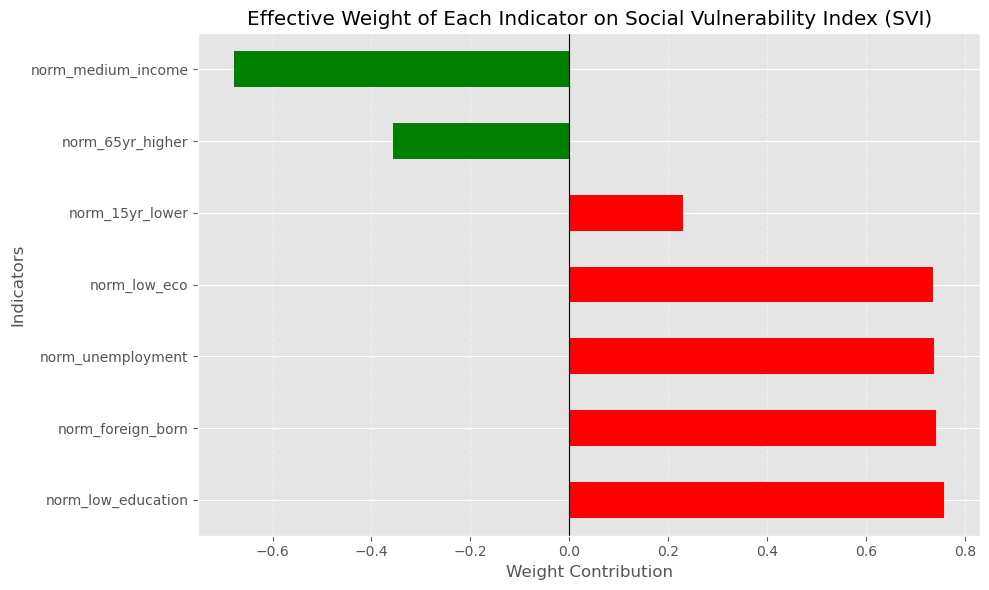

In [21]:
# =========================================================
# Calculate Effective Weights of each original indicator on the final SVI
# =========================================================

# 1. Verify existence of previous variables
# loadings: Loadings matrix DataFrame generated in Step 5
# weights: Component weights generated in Step 6 (e.g., [0.74, 0.26])

# 2. [CRITICAL] Set Direction Factors (Scenario A)
# Based on our analysis:
# RC1 (Economic Disadvantage) -> +1 (Increases Vulnerability)
# RC2 (Child/Dependency Burden) -> +1 (Increases Vulnerability)
direction_factors = np.array([1.0, 1.0]) 

print(f"Direction Factors used: {direction_factors}")
print(f"Component Weights used: {weights}")

# 3. Calculate Effective Weights
# Formula: Effective Weight = Sum( Loading * Component Weight * Component Direction )
# This represents the "net contribution" of each variable to the SVI.
indicator_effective_weights = pd.DataFrame(index=features, columns=['Effective_Weight'])
indicator_effective_weights['Effective_Weight'] = 0.0

# Iterate through each component (RC1, RC2) for weighted summation
for i in range(n_components):
    col_name = f'RC{i+1}' # e.g., RC1, RC2
    
    # Get parameters for current component
    loading_vec = loadings[col_name]     # Loadings vector for this component
    comp_weight = weights[i]             # Importance weight of this component
    direction = direction_factors[i]     # Direction of this component (+1 or -1)
    
    # Accumulate contribution
    indicator_effective_weights['Effective_Weight'] += loading_vec * comp_weight * direction

# 4. Sort and display results
# Sort by Effective Weight (descending) to see positive contributors at top, negative at bottom
# (Or you could sort by absolute value to see "magnitude of influence")
indicator_effective_weights = indicator_effective_weights.sort_values(by='Effective_Weight', ascending=False)

# Remove auxiliary columns if any, keep only the result
result_weights = indicator_effective_weights[['Effective_Weight']]

print("\n--- Final Effective Weights of Indicators (Sorted by Value) ---")
print("Legend:")
print("  (+) Positive: Higher indicator value INCREASES Social Vulnerability (Increases SVI)")
print("  (-) Negative: Higher indicator value DECREASES Social Vulnerability (Decreases SVI)")
print("-" * 60)
print(result_weights.round(4))
print("-" * 60)

# 5. Visualize Weights (Bar Chart)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Set color: Red for positive (increasing vulnerability), Green for negative (decreasing vulnerability)
colors = ['red' if x > 0 else 'green' for x in result_weights['Effective_Weight']]

result_weights['Effective_Weight'].plot(kind='barh', color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Effective Weight of Each Indicator on Social Vulnerability Index (SVI)')
plt.xlabel('Weight Contribution')
plt.ylabel('Indicators')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()